In [0]:
import pandas as pd
import numpy as np

In [44]:
df = pd.read_csv('training.csv')
df.head()

,text,label
0,dumb nigger,"[1, 0, 0]"
1,yanke winnnn,"[0, 0, 1]"
2,kuroda gave hi put career number get run suppo...,"[0, 0, 1]"
3,shi peopl tend great observ skill make easier ...,"[0, 0, 1]"
4,fuck niggah gay lol,"[0, 1, 0]"


In [45]:
df.groupby('label').count()

,text
label,
"[0, 0, 1]",4994
"[0, 1, 0]",1400
"[1, 0, 0]",2000


In [19]:
embedding_ = np.load('embeddings_latest.npy')
embedding_.shape

(19210, 256)

In [0]:
from keras.models import Sequential, load_model, save_model
from keras.layers import Embedding, Dropout, Bidirectional, LSTM, Dense
INPUT_SIZE = 512
def get_model(embedding, vocab_size=INPUT_SIZE):
    model = Sequential()
    model.add(Embedding(*embedding.shape, weights=[embedding], input_length=vocab_size, name='Embedding_Layer'))
    model.add(Dropout(0.2, name="Dropout"))
    model.add(Bidirectional(LSTM(vocab_size, dropout=0.1, recurrent_dropout=0.25, name="Bi-LSTM_Layer_1")))

    model.add(Dense(64, activation='relu', name="Dense_64"))
    model.add(Dense(32, activation='relu', name="Dense_32"))
    model.add(Dense(3, activation='sigmoid',name='Dense_3'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy', 'accuracy'])
    print(model.summary())
    return model

In [21]:
model = get_model(embedding_, INPUT_SIZE)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding_Layer (Embedding)  (None, 512, 256)          4917760   
_________________________________________________________________
Dropout (Dropout)            (None, 512, 256)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1024)              3149824   
_________________________________________________________________
Dense_64 (Dense)             (None, 64)                65600     
_________________________________________________________________
Dense_32 (Dense)             (None, 32)                2080      
_________________________________________________________________
Dense_3 (Dense)      

In [24]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [25]:
!pip3 install keras_tqdm

In [46]:
import pickle
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from ast import literal_eval
dataset = pd.read_csv('training.csv')
_X, _y = dataset['text'].astype('str'), dataset['label']
tokenizer = pickle.load(open('tokenizer.pkl', 'rb'))
X = tokenizer.texts_to_matrix(_X)
y = np.array(list(map(lambda label: literal_eval(label), _y)))
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=69, test_size=0.0)
X_train.shape, X_test.shape


((8400, 512), (0, 512))

In [47]:
from keras_tqdm import TQDMNotebookCallback
import datetime
history = model.fit(X_train, y_train, batch_size=64, epochs=4, validation_split=0.2, verbose=0, callbacks=[TQDMNotebookCallback()])
model_name = f"model_{datetime.datetime.now()}.h5"
model.save(model_name)

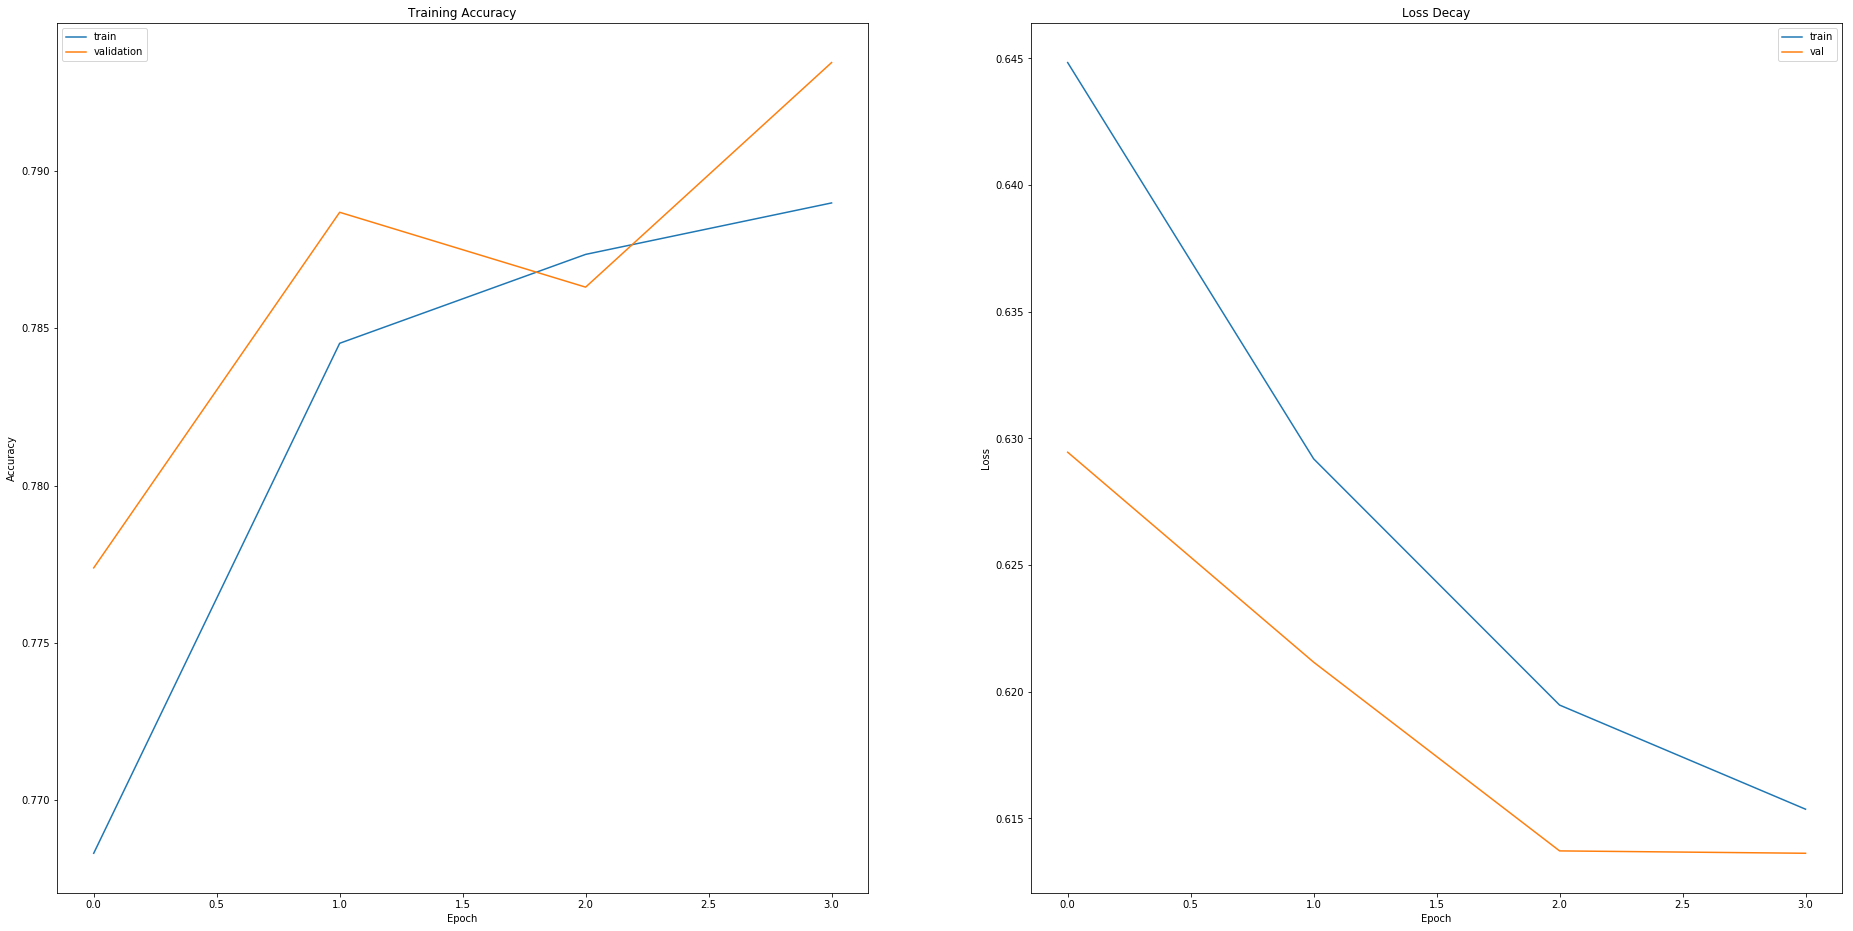

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(32, 16))
fig.add_subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['train', 'validation'], loc='upper left')
plt.title("Training Accuracy")
plt.xlabel("Epoch"), plt.ylabel("Accuracy")
fig.add_subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Decay')
plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')

In [60]:
from keras.utils import plot_model
test_df = pd.read_csv('final.csv')[['text', 'label']]
model = load_model(model_name)  # change this to the corresponding model file
# plot_model(model, to_file='model.png')
print(test_df.head(), test_df.shape, sep='\n')
print(model.summary())

                                                text      label
0            mr. mine you say babe what's yeah first  [0, 0, 1]
1  mr. mine you say babe what's yeah first of a d...  [0, 0, 1]
2            of a dynamic punch get it good mr. line  [0, 0, 1]
3  of a dynamic punch get it good mr. line you'll...  [0, 0, 1]
4               you'll get stronger glabra it's your  [0, 0, 1]
(6822, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding_Layer (Embedding)  (None, 512, 256)          4917760   
_________________________________________________________________
Dropout (Dropout)            (None, 512, 256)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1024)              3149824   
_________________________________________________________________
Dense_64 (Dense)             (None, 64)                65600     
____________

In [71]:
test_df = test_df.sample(frac=1).reset_index(drop=True)
_X_test, y_test = test_df.text, np.array([literal_eval(_) for _ in test_df.label.values.tolist()])
_X_test.shape

(6822,)

In [72]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
wnl = WordNetLemmatizer()
ps = PorterStemmer()
en_stops = set(stopwords.words('english'))
_X_test = _X_test.map(lambda x: ' '.join(list(filter(lambda y: y not in en_stops, [ps.stem(wnl.lemmatize(_)) for _ in x.split(' ')]))))
_X_test.shape

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


(6822,)

In [73]:
tokenizer = pickle.load(open('tokenizer.pkl', 'rb'))
X_test = tokenizer.texts_to_matrix(_X_test)
X_test.shape

(6822, 512)

In [0]:
y_hat = model.predict(X_test)

In [75]:
from sklearn.metrics import classification_report
from keras.utils import to_categorical
y_hat_ = to_categorical([np.argmax(_) for _ in y_hat], num_classes=3).astype('int')
print(classification_report(y_test, y_hat_))

              precision    recall  f1-score   support

           0       0.83      0.15      0.25      1280
           1       0.53      0.40      0.46      1068
           2       0.90      0.98      0.94      5298

   micro avg       0.85      0.76      0.80      7646
   macro avg       0.75      0.51      0.55      7646
weighted avg       0.84      0.76      0.76      7646
 samples avg       0.85      0.81      0.83      7646



In [76]:
labels = [[0, 1, 0], [0, 0, 1], [1, 0, 0]]
print([np.count_nonzero(y_hat_ == label) for label in labels])
print([np.count_nonzero(y_test == label) for label in labels])

[8422, 18418, 7270]
[8134, 16594, 8558]
